In [34]:
# First, we will load up some dependencies. Make sure you can get through this part first. 
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline  

Now we are going to load the data in. I have already saved off two images, a '9' and a '4', to keep things simple for us. We also reshape them into their native [28 x 28] size, so that we can later corrupt them in this domain, and then reconstruct them.

In [35]:
data = (np.load('data_to_train_on.npy')).astype(np.float32).reshape(2,28,28)

What does our data look like? Well they are just two binary images, showing a figure '9', and a figure '4'. Let's image them just to take a peek at what they look like. 

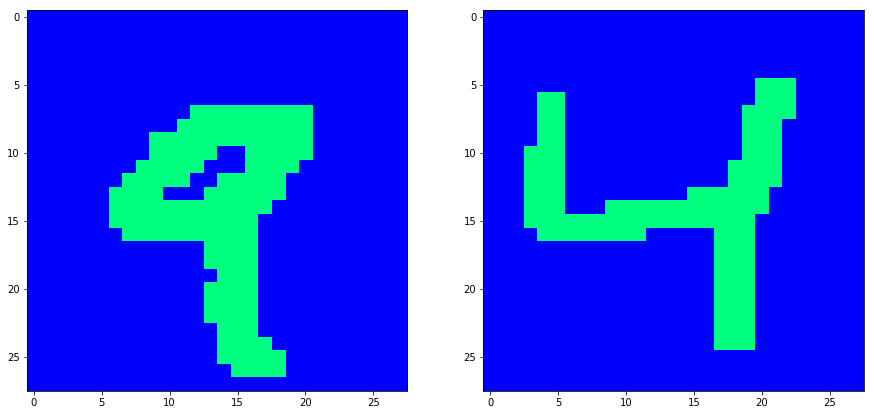

In [36]:
# Show the training data - it's just two different samples that we are going to want the Hopfield net to store.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(data[0], interpolation='None', cmap='winter')
ax[1].imshow(data[1], interpolation='None', cmap='winter')
plt.show()

In [46]:
# Here, we will set some initial parameters, as well as define some helper functions used in the training and fielding
# of the Hopfield net

# This is a cool way to make it so that we can store ad-hoc members in a struct. I find it handy, where I use 
# "N" for "number of things", and "I" to keep track of various indices. Personal preference.
N = lambda:0
I = lambda:0

# Train function for the hopfield net. (By updating the weights)
def train_hopfield_weights(data, weights):
    # data : A [d x rows x cols] numpy array of data. 'd' is the number of data samples used to train. (In this case 2)
    # weights : A [rows*cols x rows*cols] matrix of the hopfield weights, initialized with 0s.

    # First, we vectorize our data:
    data = data.reshape((-1, 1, data.shape[1]*data.shape[2]))
    
    # Number of patterns to store/train with.
    N.data = data.shape[0]    

    # Loop through all data samples.
    for dd in xrange(N.data):

        # Data cross-product gives neural hopfield update rule.
        w_update = data[dd].T * data[dd]
        
        # Sum all pattern cross-products.
        weights += w_update

    # Hopfield nets are a form of RNNs, albeit without self-connections, and so, we need to make sure that the 
    # diagonal elements of the final weight matrix are zero. 
    np.fill_diagonal(w_update, 0)
                
    # Return our new weights
    return (weights.astype(np.float32))


# This function computes the Hopfield nets' energy.
def energy(x, w):
    # x: [1 x N] data vector
    # w: [N x N] hopfield net weight matrix.
    energy = -x.dot(w).dot(x.T)
    return energy

# We will use this function to take in a good image, and corrupt it, based on two types of noise, either bernouli noise,
# (where every pixel is randomly flipped in sign), or masking noise, where we blot out entire sections of the image. Our
# Hopfield net will be able to recover the original image via energy minimization as we will see.
def corrupt_input(image_to_corrupt, method, bernouli_noise_probability = 0.1, mask_value = -1, mask_matrix=np.zeros((2,2))):
    if method == 'bernouli':
        noise_image = (-1*np.random.binomial(1, bernouli_noise_probability, (image_to_corrupt.shape[0], image_to_corrupt.shape[1]))).astype(np.float32)
        noise_image[noise_image==0] = 1
        corrupted_image = noise_image * image_to_corrupt
    elif method == 'mask':
        corrupted_image = np.copy(image_to_corrupt)
        corrupted_image[mask_matrix[0,0]:mask_matrix[0,1], 
                        mask_matrix[1,0]:mask_matrix[1,1]] = mask_value

    return corrupted_image    

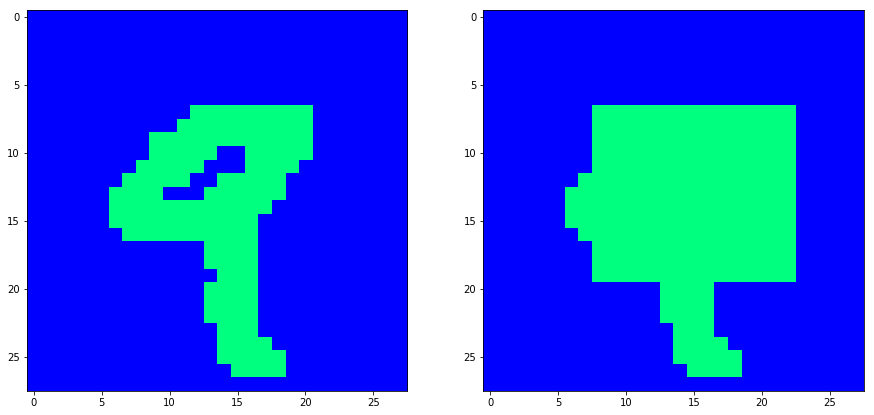

In [51]:
image = data[0]
# corrupted_image = corrupt_input(image, method='bernouli', bernouli_noise_probability=0.1)
mask_matrix = np.zeros((2,2)).astype(np.int32)
mask_matrix[0,0] = 7
mask_matrix[0,1] = 20
mask_matrix[1,0] = 8
mask_matrix[1,1] = 23
corrupted_image = corrupt_input(image, method='mask', mask_value=1, mask_matrix=mask_matrix)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(data[0], interpolation='None', cmap='winter')
ax[1].imshow(corrupted_image, interpolation='None', cmap='winter')
plt.show()



Fin


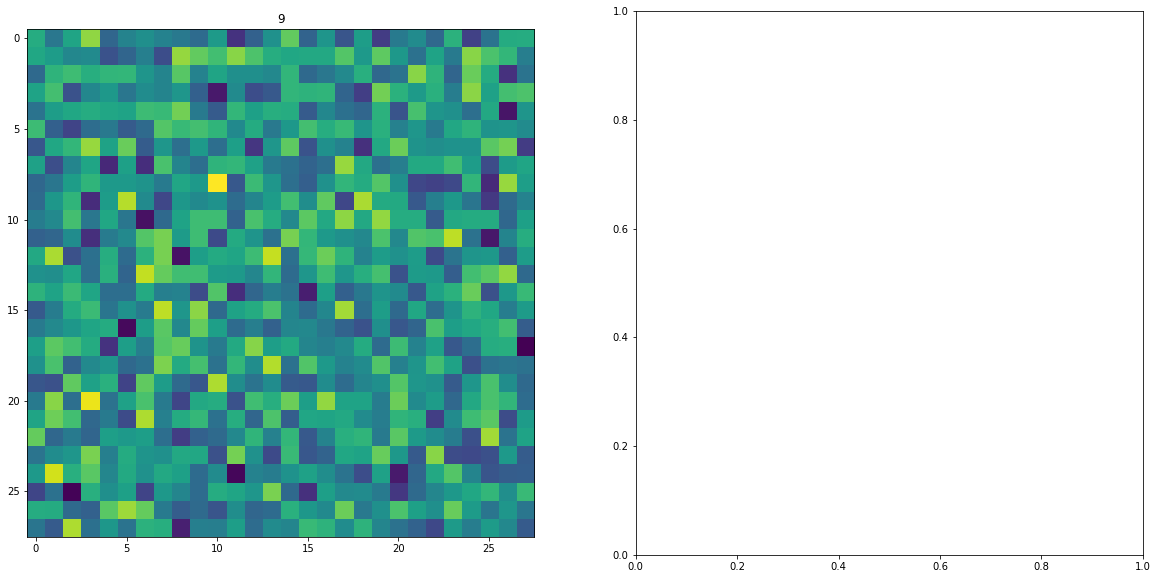

In [10]:

from time import sleep

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))

for ii in xrange(10):
    im = np.random.randn(28,28)
    ax[0].cla()
    ax[0].imshow(im, interpolation='None')
    ax[0].set_title(ii)
    fig.canvas.draw()
    sleep(0.1)

print 'Fin'